# Upload data to Colab

In [0]:
import json
from pprint import pprint
from google.colab import auth
from googleapiclient.discovery import build
import io
from googleapiclient.http import MediaIoBaseDownload
import pickle

**You'll be prompted for your google credentials after running next cell**

In [0]:
auth.authenticate_user()
drive_service = build('drive', 'v3')

In [0]:
def _create_file_request(file_id):
    return drive_service.files().get_media(fileId=file_id)


def _download_response_bytes(request, print_progress=False):
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    
    for status in _progbar(downloader):
        if print_progress:
            print("Downloaded {}/{} bytes".format(status.resumable_progress, status.total_size))
  
    downloaded.seek(0)
    return downloaded.read()

  
def _progbar(downloader):
    done = False
    while done is False:
        status, done = downloader.next_chunk()
        yield status


def get_file_id(name):
    return get_matching_files(name)[0]['id']


def move_from_drive_to_disk(file_names, file_destinations):
    for file_name, dest in zip(file_names, file_destinations):
        file_id = get_file_id(file_name)
        print('Downloading file: "{}"'.format(file_name))
        file_bytes = _download_response_bytes(_create_file_request(file_id), print_progress=True)
        with open(dest, "wb") as f:
            f.write(file_bytes)


def load_pickled_files(file_names):
    for name in file_names:
        yield pickle.load(open(name, "rb"))
        

def get_matching_files(name):
    drive_files_response = _download_response_bytes(drive_service.files().list())
    drive_files_response_dict = json.loads(
        drive_files_response.decode('utf-8')
    )
    drive_files_dict = drive_files_response_dict['files']
  
    matching_records = [
        record
        for record in drive_files_dict
        if record['name'] == name
    ]

    no_records = len(matching_records)
    if no_records == 0:
        raise ValueError('no such file: "{}" on your Google Drive'.format(name))
    elif no_records > 1:
        print('warning: multiple matches for file "{}"'.format(name))
    return matching_records

Assume you have file named `data.zip` on your google drive.

In [4]:
example_file_name = 'train_test_data.zip'
example_file_id = get_file_id(example_file_name)

In [5]:
move_from_drive_to_disk([example_file_name], ['train_test_data.zip'])

Downloaded 104857601/212781105 bytes
Downloaded 209715202/212781105 bytes
Downloaded 212781105/212781105 bytes


In [6]:
!unzip train_test_data.zip
!rm train_test_data.zip
!mv train_test_data data

Archive:  train_test_data.zip
   creating: train_test_data/
   creating: train_test_data/dt05_bth/
  inflating: train_test_data/dt05_bth/F01_050C0103_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C0105_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C010C_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C010G_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C010J_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C010K_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C010L_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C010O_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C010P_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C010R_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C010U_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C010W_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C0112_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C0116_BTH.C

# Program

In [6]:
%matplotlib inline

! pip install -q librosa nltk

import tensorflow as tf
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
import matplotlib.pyplot as plt
from functools import partial
import numpy as np
import librosa
import glob
from librosa.core import load, stft, magphase, istft
from librosa.output import write_wav
import soundfile as sf

plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['image.cmap'] = 'hot'

In [8]:
def read_audio(path, sample_rate):
    mono, native_sr = sf.read(path)
    if native_sr != sample_rate:
        mono = librosa.core.resample(mono, native_sr, sample_rate)
    return np.expand_dims(mono, 1)

def fake_stereo(audio):
    stereo = audio[:, 0]
    return np.stack((stereo, stereo), axis=1)

def compute_spectrogram(audio, n_fft, fft_hop):
    
    def stft(x):
        spec = librosa.stft(
            x, n_fft=n_fft, hop_length=fft_hop, window='hann')
        mag, _ = magphase(spec)
        return mag
    
    def mono_func(py_audio):
        mag = stft(py_audio[:, 0])
        return mag.T.astype(np.float32)
    
    ret = mono_func(audio)
    np.reshape(ret, (-1, 1 + n_fft // 2, 1))
    return ret

def extract_spectrogram_patches(spec, n_fft, patch_window, patch_hop):
    spec3d = np.expand_dims(spec, axis=0)
    spec4d = np.expand_dims(spec3d, axis=3)

    patches = tf.extract_image_patches(
        images=spec4d,
        ksizes=[1, patch_window, 1 + n_fft / 2, 1],
        strides=[1, patch_hop, 1 + n_fft / 2, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'
    ).eval()

    num_patches = patches.shape[1]

    return np.reshape(patches, (num_patches, patch_window, int(1 + n_fft // 2), 1))

def partial_argv(func, *args, **kwargs):
    return lambda *other_args: tuple(map(partial(func, *args, **kwargs), other_args))

In [9]:
def training_dataset(
        pattern,
        sample_rate,
        n_fft,
        fft_hop,
        patch_window,
        patch_hop
):
    paths = sorted(glob.glob(pattern))
    audio = list(map(partial(read_audio, sample_rate=sample_rate), paths))
    stereo = list(map(fake_stereo, audio))
    spectrogram = list(map(partial(compute_spectrogram, n_fft=n_fft, fft_hop=fft_hop), stereo))
    with tf.Session() as sess:
        data = list(map(partial(extract_spectrogram_patches, n_fft=n_fft, patch_window=patch_window, patch_hop=patch_hop), spectrogram))
    
    return data

In [10]:
SAMPLE_RATE = 44100
N_FFT = 1024
FFT_HOP = 256
N_CHANNELS = 1  
N_PARALLEL_READERS = 4
PATCH_WINDOW = 256
PATCH_HOP = 128
BATCH_SIZE = 8
N_SHUFFLE = 20

In [26]:
voice = training_dataset('/home/enterprise.internal.city.ac.uk/acvn728/LibriSpeechMini/Mixed/train-clean-100/**/*.flac', SAMPLE_RATE, N_FFT, FFT_HOP, PATCH_WINDOW, PATCH_HOP)
mixed = training_dataset('/home/enterprise.internal.city.ac.uk/acvn728/LibriSpeechMini/Mixed/train-clean-100/**/*.flac', SAMPLE_RATE, N_FFT, FFT_HOP, PATCH_WINDOW, PATCH_HOP)

#directory_a = '/home/enterprise.internal.city.ac.uk/acvn728/LibriSpeechMini/Mixed/train-clean-100/19/198/'
#directory_b = '/home/enterprise.internal.city.ac.uk/acvn728/LibriSpeechMini/Voice/train-clean-100/19/198/'

In [27]:
print(len(voice))
print(len(mixed))
print(voice[1].shape)
print(mixed[1].shape)

0
0


IndexError: list index out of range

In [14]:
def roll(arr,shift):
    shape = arr.shape
    arr = arr.reshape(shape[0]*shape[1],shape[2],shape[3])
    arr = np.roll(arr, shift, axis=0)
    return arr.reshape(shape[0],shape[1],shape[2],shape[3])

In [15]:
voice = list(map(partial(roll,shift=-4), voice))

# Test

In [16]:
voice = np.vstack(voice)
mixed = np.vstack(mixed)

IndexError: index 490 is out of bounds for axis 0 with size 80

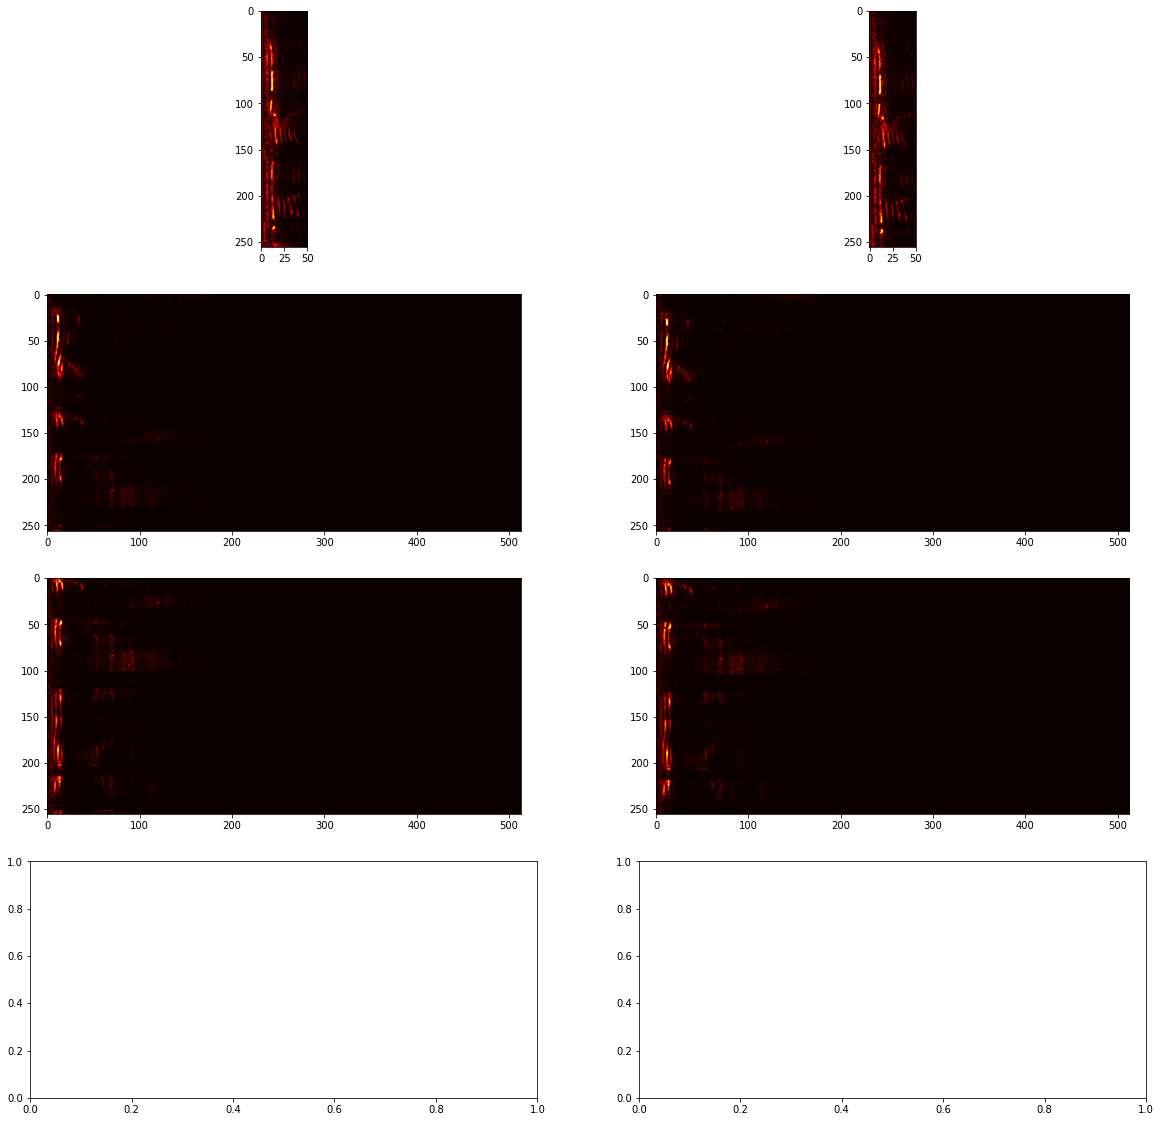

In [17]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(20,20))
ax1.imshow(voice[14, :, :50, 0])
ax2.imshow(mixed[14, :, :50, 0])
ax3.imshow(voice[1, :, :, 0])
ax4.imshow(mixed[1, :, :, 0])
ax5.imshow(voice[2, :, :, 0])
ax6.imshow(mixed[2, :, :, 0])
ax7.imshow(voice[490, :, :, 0])
ax8.imshow(mixed[490, :, :, 0])

In [18]:
train_voice = voice[:,:,:512,:]
train_mixed = mixed[:,:,:512,:]

In [19]:
print(train_mixed.shape)
print(train_voice.shape)

(80, 256, 512, 1)
(80, 256, 512, 1)


In [20]:
input_size = (256, 512, 1)
inputs = Input(input_size)
conv1 = Conv2D(16, 5, strides=2, padding='same')(inputs)
conv1 = BatchNormalization()(conv1)
conv1 = LeakyReLU(alpha=0.2)(conv1)

conv2 = Conv2D(32, 5, strides=2, padding='same')(conv1)
conv2 = BatchNormalization()(conv2)
conv2 = LeakyReLU(alpha=0.2)(conv2)

conv3 = Conv2D(64, 5, strides=2, padding='same')(conv2)
conv3 = BatchNormalization()(conv3)
conv3 = LeakyReLU(alpha=0.2)(conv3)

conv4 = Conv2D(128, 5, strides=2, padding='same')(conv3)
conv4 = BatchNormalization()(conv4)
conv4 = LeakyReLU(alpha=0.2)(conv4)

conv5 = Conv2D(256, 5, strides=2, padding='same')(conv4)
conv5 = BatchNormalization()(conv5)
conv5 = LeakyReLU(alpha=0.2)(conv5)

conv6 = Conv2D(512, 5, strides=2, padding='same')(conv5)
conv6 = BatchNormalization()(conv6)
conv6 = LeakyReLU(alpha=0.2)(conv6)

deconv7 = Deconv2D(256, 5, strides=2, padding='same')(conv6)
deconv7 = BatchNormalization()(deconv7)
deconv7 = Dropout(0.5)(deconv7)
deconv7 = Activation('relu')(deconv7)

deconv8 = Concatenate(axis=3)([deconv7, conv5])
deconv8 = Deconv2D(128, 5, strides=2, padding='same')(deconv8)
deconv8 = BatchNormalization()(deconv8)
deconv8 = Dropout(0.5)(deconv8)
deconv8 = Activation('relu')(deconv8)

deconv9 = Concatenate(axis=3)([deconv8, conv4])
deconv9 = Deconv2D(64, 5, strides=2, padding='same')(deconv9)
deconv9 = BatchNormalization()(deconv9)
deconv9 = Dropout(0.5)(deconv9)
deconv9 = Activation('relu')(deconv9)

deconv10 = Concatenate(axis=3)([deconv9, conv3])
deconv10 = Deconv2D(32, 5, strides=2, padding='same')(deconv10)
deconv10 = BatchNormalization()(deconv10)
deconv10 = Activation('relu')(deconv10)

deconv11 = Concatenate(axis=3)([deconv10, conv2])
deconv11 = Deconv2D(16, 5, strides=2, padding='same')(deconv11)
deconv11 = BatchNormalization()(deconv11)
deconv11 = Activation('relu')(deconv11)

deconv12 = Concatenate(axis=3)([deconv11, conv1])
deconv12 = Deconv2D(1, 5, strides=2, padding='same')(deconv12)
deconv12 = Activation('relu')(deconv12)

model = Model(inputs=inputs, outputs=deconv12)

model.compile(optimizer=Adam(1e-4), loss='mean_absolute_error')

In [21]:
model.fit(train_mixed, train_voice, batch_size=4,epochs=5)
#model.fit(train_mixed, train_voice, epochs=10, validation_split=0.2, verbose=2)

Epoch 1/5
80/80 [==============================] - 6s 76ms/step - loss: 0.4755
Epoch 2/5
80/80 [==============================] - 1s 9ms/step - loss: 0.4124
Epoch 3/5
80/80 [==============================] - 1s 9ms/step - loss: 0.3675
Epoch 4/5
80/80 [==============================] - 1s 9ms/step - loss: 0.3355
Epoch 5/5
80/80 [==============================] - 1s 9ms/step - loss: 0.3128


In [22]:
voice_pred = model.predict(train_mixed[:4, :, :, :])

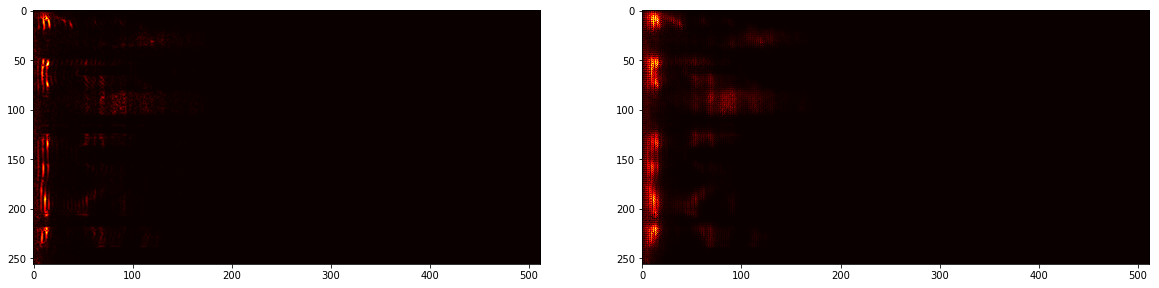

In [23]:
fig, ((ax1,ax2)) = plt.subplots(1, 2, figsize=(20,20))
ax1.imshow(train_mixed[2, :, :, 0])
ax2.imshow(voice_pred[2, :, :, 0])

In [0]:
audio, _ = librosa.load('/content/data/dt05_bus_simu/F01_050C0103_BUS.CH1.wav', sr=44100, mono=True)

In [0]:
spec = librosa.stft(audio, n_fft=1024, hop_length=256, window='hann')

In [0]:
mag, phase = magphase(spec)
mag = mag.T.astype(np.float32)

In [37]:
print(spec.shape)
print(mag.shape)
print(phase.shape)

(513, 1075)
(1075, 513)
(513, 1075)


In [0]:
with tf.Session() as sess:
    spectrogram = extract_spectrogram_patches(mag, N_FFT, PATCH_WINDOW, PATCH_HOP)

In [0]:
spectrogram = spectrogram[:,:,:512,:]

In [42]:
spectrogram.shape

(7, 256, 512, 1)

In [0]:
voice_spec_pred = model.predict(spectrogram)

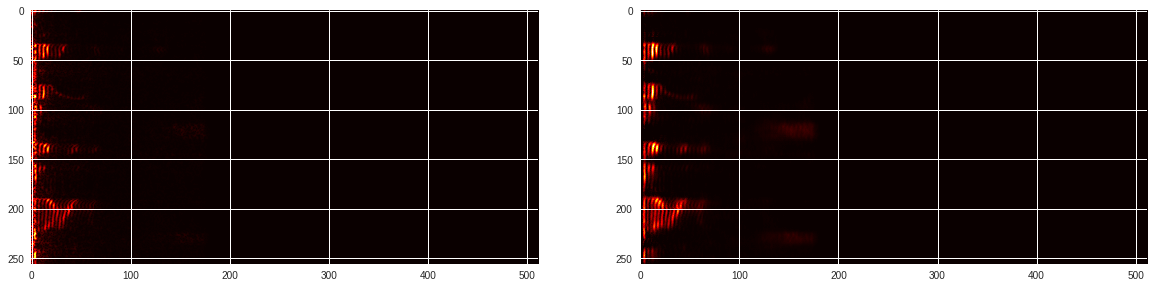

In [44]:
fig, ((ax1,ax2)) = plt.subplots(1, 2, figsize=(20,20))
ax1.imshow(spectrogram[2, :, :, 0])
ax2.imshow(voice_spec_pred[2, :, :, 0])

In [0]:
def reverse_extract_spectrogram_patches(spec):
    spec2 = spec.reshape(1,-1,512,1)
    
    with tf.Session() as sess:
        patches = tf.extract_image_patches(
            images=spec2,
            ksizes=[1, 128, 512, 1],
            strides=[1, 256, 512, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        ).eval()

    return np.concatenate((patches.reshape(1,-1,512,1), spec2[:,-128:,:,:]), axis=1)

In [0]:
spectrogram_r = reverse_extract_spectrogram_patches(voice_spec_pred)

In [52]:
spectrogram_r.shape

(1, 1024, 512, 1)

In [53]:
spectrogram_r2 = spectrogram_r[0,:,:,0].T
spectrogram_r2.shape

(512, 1024)

In [0]:
mag = np.vstack((spectrogram_r2, np.zeros((spectrogram_r2.shape[1]))))

In [59]:
mag.shape

(513, 1024)

In [60]:
phase.shape

(513, 1075)

In [0]:
n = phase.shape[1] // PATCH_HOP * PATCH_HOP
phase = phase[:,:n]

In [62]:
phase.shape

(513, 1024)

In [0]:
write_wav(f'test.wav', istft(mag*phase, win_length=N_FFT, hop_length=FFT_HOP, window='hann'), SAMPLE_RATE, norm=True)